In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pandas as pd
from collections import Counter
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
from urllib import request
from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
from ppxf.ppxf_util import log_rebin
import os
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math
import csv
from scipy import ndimage
import glob
from time import time 
from astropy.wcs import WCS
import matplotlib.ticker as ticker

In [2]:
fluxos='/home/sabrinadopico/Área de trabalho/análise3866/fluxos/'
outputvoronoi='/home/sabrinadopico/Área de trabalho/análise3866/outputsvoronoi/'

3.2125259999999994e+26
RA Min: 24.138016327971524, RA Max: 24.138723940784654
Dec Min: 13.974269373990891, Dec Max: 13.97472769132553


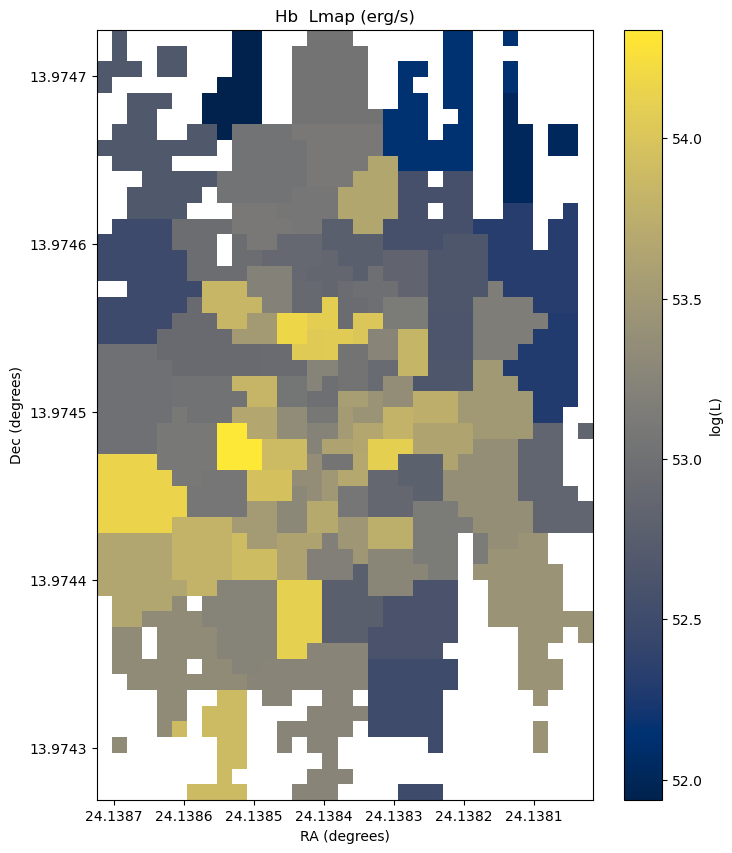

In [3]:

# Definindo o WCS
wcs_params = {
    'CTYPE1': 'RA---TAN',     # Projeção tangente para RA
    'CTYPE2': 'DEC--TAN',     # Projeção tangente para Dec
    'CRPIX1': 3134.20381624,            # Ponto de referência para o eixo 1 (pixel)
    'CRPIX2': 2089.65827139703,            # Ponto de referência para o eixo 2 (pixel)
    'CRVAL1': 24.0925255955211,    # RA da estrela guia (graus)
    'CRVAL2': 13.9448116152325,    # Dec da estrela guia (graus)
    'CD1_1': -1.43037913232859E-05,            # Escala de RA (graus por pixel)
    'CD2_2': -1.43182793542337E-05,            # Escala de Dec (graus por pixel)
    'RADECSYS': 'FK5',        # Sistema de coordenadas
    'EQUINOX': 2000.0         # Equinócio do sistema de coordenadas
}

wcs = WCS(naxis=2)  # Dois eixos, RA e Dec
wcs.wcs.ctype = [wcs_params['CTYPE1'], wcs_params['CTYPE2']]
wcs.wcs.crpix = [wcs_params['CRPIX1'], wcs_params['CRPIX2']]
wcs.wcs.crval = [wcs_params['CRVAL1'], wcs_params['CRVAL2']]
wcs.wcs.cd = [[wcs_params['CD1_1'], 0], [0, wcs_params['CD2_2']]]
wcs.wcs.radesys = wcs_params['RADECSYS']
wcs.wcs.equinox = wcs_params['EQUINOX']


bins_flux = pd.read_csv(fluxos+'fluxos_totais_hb.dat',skiprows=1, names=['Arquivo', 'Fluxo Totalhb'])
coords_bins = pd.read_csv(outputvoronoi+'voronoi_n2.txt', sep='\s+',skiprows=1, names=['X', 'Y', 'BIN_NUM'])
merged_data = coords_bins.merge(bins_flux, left_on='BIN_NUM', right_on='Arquivo', how='left')
merged_data.dropna(subset=['X', 'Y', 'Fluxo Totalhb'], inplace=True)
merged_data['X'] = pd.to_numeric(merged_data['X'], errors='coerce')
merged_data['Y'] = pd.to_numeric(merged_data['Y'], errors='coerce')
merged_data['Fluxo Totalhb'] = (pd.to_numeric(merged_data['Fluxo Totalhb'], errors='coerce'))
merged_data.dropna(subset=['X', 'Y', 'Fluxo Totalhb'], inplace=True)


x_max = int(merged_data['X'].max()) + 1
y_max = int(merged_data['Y'].max()) + 1
lum_map = np.full((y_max, x_max), np.nan)
d_l=104.1* 3.086e24 #(Obtida no https://astro.ucla.edu/~wright/CosmoCalc.html)
print(d_l)
for _, row in merged_data.iterrows():
    x, y, flux = int(row['X']), int(row['Y']), row['Fluxo Totalhb']
    luminosity= 4 * np.pi * (d_l**2) * flux
    lum_map[y,x]=luminosity


x_dim, y_dim = lum_map.shape
# Gerando as coordenadas de pixel
pixels_x, pixels_y = np.meshgrid(np.arange(x_dim), np.arange(y_dim), indexing='xy')

# Convertendo para coordenadas RA e Dec
ra_dec = wcs.all_pix2world(pixels_x.flatten(), pixels_y.flatten(), 1)


# Ajuste os limites para garantir que o campo de visão esteja correto
ra_min, ra_max = ra_dec[0].min(), ra_dec[0].max()
dec_min, dec_max = ra_dec[1].min(), ra_dec[1].max()

# Se os valores forem muito amplos, tente ajustar manualmente ou verificar os dados
print(f"RA Min: {ra_min}, RA Max: {ra_max}")
print(f"Dec Min: {dec_min}, Dec Max: {dec_max}")


# Plotando o mapa com limites manuais
plt.figure(figsize=(8, 10))
plt.imshow(np.log10(lum_map), origin='lower', cmap='cividis', aspect='auto',
           extent=[ra_min, ra_max, dec_min, dec_max])
plt.colorbar(label='log(L)')
plt.xlabel('RA (degrees)')

plt.ylabel('Dec (degrees)')
plt.title('Hb  Lmap (erg/s)')  # Inverter o eixo RA se necessário
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.xaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.yaxis.get_major_formatter().set_scientific(False)
plt.gca().invert_xaxis()  # Inverter o eixo RA se necessário
plt.show()